In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add the directory to Python path
import sys
sys.path.append('/content/drive/MyDrive')

from scipy.linalg import svd

Mounted at /content/drive


In [ ]:
%run /content/drive/MyDrive/DeepONet/utils/deeponet_lib.ipynb

Using cuda device


## 3. Darcy flow (infinite dimensional parameter)


Consider a simplified Darcy flow model featuring a spatially distributed parameter (permeability field), namely

$$\begin{cases}-\nabla\cdot(k\nabla p) = f & \text{in}\;\Omega\\-\nabla p\cdot\boldsymbol{n}\equiv0 & \text{on}\;\partial\Omega\\\int_{\Omega}p=0\end{cases}$$

where $\Omega\subset\mathbb{R}^{2}$ is the spatial domain, $p:\Omega\to\mathbb{R}$ is the pressure field and $\boldsymbol{n}$ is the unit normal. The permeability field, $k:\Omega\to(0,+\infty)$ is our parameter. We model it using a random field for which

$$0.1\le k \le 10.1,\quad\quad k\in\mathcal{C}(\Omega),$$

holds $\mathbb{P}$-almost surely. Specifically, we derive the latter as

$$k = 10\mathcal{S}(D e^{-\gamma Z})+0.1$$

where

- $\gamma=1/4$,
- $D:\Omega\to[0,+\infty)$ is a deterministic map, related to the "point-to-boundary-distance",
- $Z$ is a centered Gaussian random field with isotropic covariance kernel $\kappa(r)=e^{-100r^2}$,
- $\mathcal{S}$ is a scaling operator. Precisely, if $g\in\mathcal{C}(\Omega)$ is nonconstant, then $\mathcal{S}(g)$ is defined as

$$\mathcal{S}(g):=\frac{g-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}{\max_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}.$$

We are interested in learning the map

$$k\mapsto p,$$

that maps the permeability field onto the corresponding pressure field. Here, as a spatial domain $\Omega$ we consider the Elba Island. As a source term, instead, we consider a superposition of three pointwise sources (of fixed position and intensity),

$$f = \sum_{i=1}^{3}\delta_{\boldsymbol{x}_i},$$

where $\delta_{\boldsymbol{x}_i}$ denotes the Dirac delta at $\boldsymbol{x}_i$.

In [ ]:
k, pressure = load_data(id = "1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1")

Downloading...
From (original): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1
From (redirected): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1&confirm=t&uuid=6d0b7be1-b1ae-492d-99cb-356bd8d14371
To: /content/data.npz
100%|██████████| 153M/153M [00:00<00:00, 243MB/s]


In [ ]:
k.shape, pressure.shape

((1000, 9550), (1000, 9550))

In [ ]:
gdown.download(id = "16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4", output = "elba_mesh.xml")
mesh = fe.loadmesh("elba_mesh.xml")
Vh, y = get_fem_space(mesh)

Downloading...
From (original): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4
From (redirected): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4&confirm=t&uuid=1efa7676-7f64-4f6e-b6e5-352ce6709beb
To: /content/elba_mesh.xml
100%|██████████| 1.93M/1.93M [00:00<00:00, 171MB/s]


## POD-NN

In [ ]:
n_train = 800

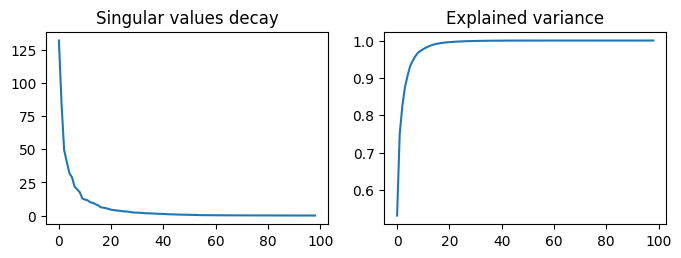

In [ ]:
X, s, Yt = svd(pressure[:n_train].T, full_matrices = False)

plt.figure(figsize = (8, 2.5))
plt.subplot(1, 2, 1)
plt.plot(s[1:100])
plt.title("Singular values decay")
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(s[1:100]**2)/np.sum(s[1:]**2))
plt.title("Explained variance")
plt.show()

In [ ]:
n = 15
V = X[:, :n]
V.shape

(9550, 15)

In [ ]:
k, pressure, V = dv.tensor(k, pressure, V)
l2 = L2(Vh)
if(dv == GPU):
  l2.cuda()
clc()

In [ ]:
pressure_test = pressure[n_train:]
pressure_proj = pressure_test @ V @ V.T

In [ ]:
mre(l2)(pressure_test, pressure_proj)

tensor(0.0197, device='cuda:0')

In [ ]:
c = pressure @ V #k --> c

In [ ]:
c.shape

torch.Size([1000, 15])

In [ ]:
p = k.shape[1]
gelu = torch.nn.functional.gelu

In [ ]:
phi = DFNN(Dense(p, 131, activation = gelu) + Dense(131, 50, activation = gelu) + Dense(50, n, activation = None))
phi.He()
phi.moveOn(dv)
phi.train(k, c, ntrain = n_train, nvalid = 50, epochs = 500, loss = mse(euclidean), nstop = 10)

		Train		Valid		Test
Epoch 76:	7.40e+00	4.63e+01	3.02e+01.

>> ETA: 3m 53.77s.

Training complete. Elapsed time: 41.81 seconds.


In [ ]:
phi.freeze()
podnn = lambda kperm : phi(kperm) @ V.T

In [ ]:
print("MRE for POD-NN: %s." % num2p(mrei(l2)(pressure[n_train:], podnn(k)[n_train:])))

MRE for POD-NN: 13.71%.


## DeepONet

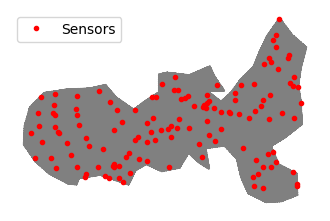

In [ ]:
# Define the sensor location
nsensors = 131
sensors = np.linspace(0, Vh.dim(), nsensors+1).astype('int')[:-1]
plt.figure(figsize = (4, 4))
fe.plot(mesh)
plt.plot(*fe.coordinates(Vh)[sensors].T, '.r', label = 'Sensors')
plt.legend()
plt.show()

In [ ]:
# Define the mesh
ymesh = dv.tensor(fe.coordinates(Vh))

# Sample the permeadbility field in the sensor location
ksens = k[:, sensors]

In [ ]:
# Config
learning_rate = 1e-3
batch_size = 1
epochs = 50

m = nsensors
d = ymesh.shape[1]
p = 15
h = 100

In [ ]:
# Build the model
model = DeepONet(m,d,p,h)
model.to(device)
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=131, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=15, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=15, bias=True)
  )
)


In [ ]:
# Build the dataset
train_size = n_train
val_size = 50

dataset = FomDataset(ksens, pressure, ymesh)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

<ipython-input-2-9a8cb204c24c>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu, dtype=torch.float32).to(device)
<ipython-input-2-9a8cb204c24c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(u, dtype=torch.float32).to(device)
<ipython-input-2-9a8cb204c24c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).to(device)


In [ ]:
# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/50:
Current Loss: 0.059890  [  741/  750]
Train Loss: 0.0265 | Val Loss: 0.0142 | Test Loss: 0.0136
Epoch 2/50:
Current Loss: 0.054708  [  741/  750]
Train Loss: 0.0158 | Val Loss: 0.0117 | Test Loss: 0.0116
Epoch 3/50:
Current Loss: 0.042927  [  741/  750]
Train Loss: 0.0122 | Val Loss: 0.0095 | Test Loss: 0.0094
Epoch 4/50:
Current Loss: 0.035129  [  741/  750]
Train Loss: 0.0095 | Val Loss: 0.0083 | Test Loss: 0.0079
Epoch 5/50:
Current Loss: 0.024807  [  741/  750]
Train Loss: 0.0084 | Val Loss: 0.0067 | Test Loss: 0.0063
Epoch 6/50:
Current Loss: 0.020421  [  741/  750]
Train Loss: 0.0069 | Val Loss: 0.0065 | Test Loss: 0.0059
Epoch 7/50:
Current Loss: 0.014798  [  741/  750]
Train Loss: 0.0059 | Val Loss: 0.0053 | Test Loss: 0.0048
Epoch 8/50:
Current Loss: 0.014563  [  741/  750]
Train Loss: 0.0056 | Val Loss: 0.0050 | Test Loss: 0.0045
Epoch 9/50:
Current Loss: 0.013810  [  741/  750]
Train Loss: 0.0049 | Val Loss: 0.0045 | Test Loss: 0.0041
Epoch 10/50:
Current Loss: 0

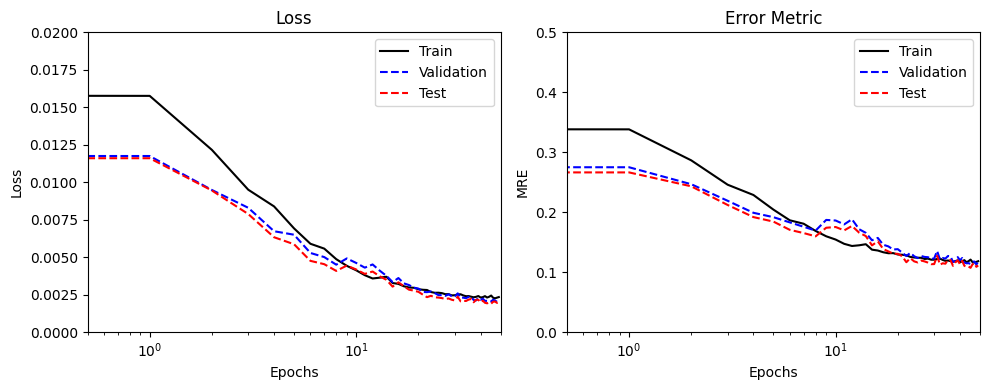

In [ ]:
plot_errors(trainer, 0.02, 0.5)

In [ ]:
print("MRE for DeepONet: %s." % num2p(trainer.train_hist['error_metric'][-1]))

MRE for DeepONet: 11.82%.


## Compare POD-NN and DeepONet

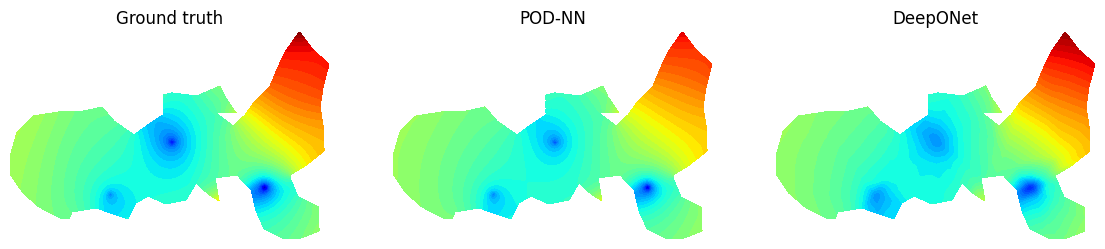

In [ ]:
j = -1

test_sample = test_set[j]
k_sens, pressure_test, y = test_sample

vmin, vmax = pressure_test.min(), pressure_test.max()
plt.figure(figsize = (14, 8))
plt.subplot(1, 3, 1)
fe.plot(pressure_test, Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("Ground truth")

plt.subplot(1, 3, 2)
fe.plot(podnn(k[j]), Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("POD-NN")

plt.subplot(1, 3, 3)
mu, true_u, y = add_batch_dimension(test_sample)
fe.plot(model(mu, y).squeeze(0).detach(), Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("DeepONet")
None